In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from google.colab import drive
import matplotlib.pyplot as plt

# 구글 드라이브 마운트
drive.mount('/content/drive')

def read_csv(file_path):
    df = pd.read_csv(file_path, header=None, skiprows=[10])
    points = df.values[:, :4]
    return points

# 이미지와 csv 파일 매칭
def prepare_dataset(image_folder, csv_folder):
    image_paths = []
    labels = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_folder, filename)
            csv_file = filename.replace(".jpg", ".csv").replace(".png", ".csv").strip()
            csv_path = os.path.join(csv_folder, csv_file)

            if os.path.exists(csv_path):
                points = read_csv(csv_path)
                image_paths.append(image_path)
                labels.append(points)
            else:
                print(f"CSV file not found for image: {filename}")

    return image_paths, labels

image_folder = '/content/drive/My Drive/LA/'
csv_folder = '/content/drive/My Drive/LA/'
split_csv_path = '/content/drive/My Drive/spine_data_filtered1.csv'

image_paths, labels = prepare_dataset(image_folder, csv_folder)

split_info_df = pd.read_csv(split_csv_path)
split_info_df['filename'] = split_info_df['filename'].str.strip()

split_info_df['filename_trimmed'] = split_info_df['filename'].str[:-1]

# train, test, validation 데이터 준비
train_images, train_labels = [], []
test_images, test_labels = [], []
val_images, val_labels = [], []

for i, filename in enumerate(image_paths):
    base_filename = os.path.splitext(os.path.basename(filename))[0]
    base_filename_trimmed = base_filename[:-1]

    matching_row = split_info_df[split_info_df['filename_trimmed'] == base_filename_trimmed]

    split_value = matching_row['split'].values[0]

    if split_value == 'Train':
      train_images.append(image_paths[i])
      train_labels.append(labels[i])

    elif split_value == 'Test':
      test_images.append(image_paths[i])
      test_labels.append(labels[i])

    elif split_value == 'Valid':
      val_images.append(image_paths[i])
      val_labels.append(labels[i])

print(f"Training Images: {len(train_images)}, Training Labels: {len(train_labels)}")
print(f"Testing Images: {len(test_images)}, Testing Labels: {len(test_labels)}")
print(f"Validating Images: {len(val_images)}, Validating Labels: {len(val_labels)}")

# 이미지와 마스크 로딩
def load_images_and_masks(image_paths, labels, img_size=(256, 256), num_classes=6):
    images = []
    masks = []

    for i, image_path in enumerate(image_paths):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        original_height, original_width = image.shape[:2]
        image_resized = cv2.resize(image, img_size)
        mask = np.zeros(img_size, dtype=np.uint8)

        for row_k, (x1, y1, x2, y2) in enumerate(labels[i][::2]):
            x3, y3, x4, y4 = labels[i][row_k * 2 + 1]

            # 좌표 스케일링
            x1_scaled = int(x1 * img_size[1] / original_width)
            y1_scaled = int(y1 * img_size[0] / original_height)

            x2_scaled = int(x2 * img_size[1] / original_width)
            y2_scaled = int(y2 * img_size[0] / original_height)

            x3_scaled = int(x3 * img_size[1] / original_width)
            y3_scaled = int(y3 * img_size[0] / original_height)

            x4_scaled = int(x4 * img_size[1] / original_width)
            y4_scaled = int(y4 * img_size[0] / original_height)

            # 다각형 마스크 그리기
            mask = cv2.fillPoly(mask, pts=[np.array([[x1_scaled, y1_scaled], [x2_scaled, y2_scaled], [x4_scaled, y4_scaled], [x3_scaled, y3_scaled]])], color=row_k + 1)

        images.append(image_resized)
        masks.append(mask)

    return np.array(images), np.array(masks)

# 마스크 생성
X_train, Y_train = load_images_and_masks(train_images, train_labels)
X_val, Y_val = load_images_and_masks(val_images, val_labels)
X_test, Y_test = load_images_and_masks(test_images, test_labels)

# 마스크 정규화
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

# unique value 확인
unique_values_train = np.unique(Y_train)
unique_values_test = np.unique(Y_test)
unique_values_val = np.unique(Y_val)

print(f"Unique values in ground truth mask (train): {unique_values_train}")
print(f"Unique values in ground truth mask (test): {unique_values_test}")
print(f"Unique values in ground truth mask (val): {unique_values_val}")



Mounted at /content/drive
Training Images: 240, Training Labels: 240
Testing Images: 81, Testing Labels: 81
Validating Images: 79, Validating Labels: 79
Unique values in ground truth mask (train): [0 1 2 3 4 5]
Unique values in ground truth mask (test): [0 1 2 3 4 5]
Unique values in ground truth mask (val): [0 1 2 3 4 5]


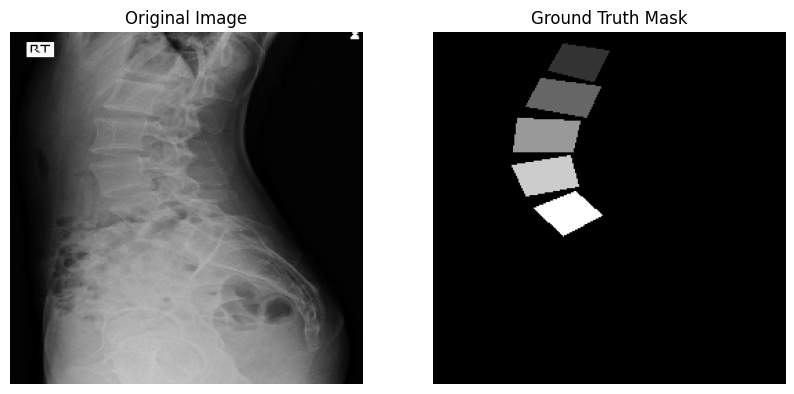

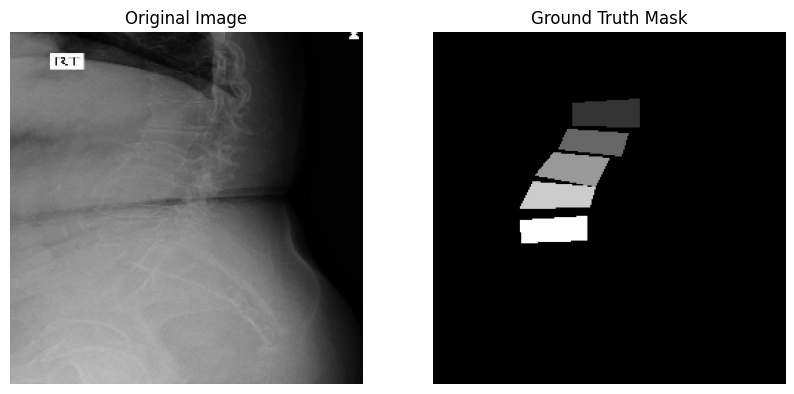

In [ ]:
import matplotlib.pyplot as plt

def display_images_with_masks(images, masks, num_images=2):

    for i in range(num_images):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # 원본 이미지
        axs[0].imshow(images[i])
        axs[0].set_title("Original Image")
        axs[0].axis("off")

        # 마스크 이미지
        axs[1].imshow(masks[i], cmap='gray')
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis("off")

        plt.show()

# 5개의 이미지 세트 시각화
display_images_with_masks(X_train, Y_train, num_images=2)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class SpineDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.transpose(self.images[idx], (2, 0, 1))
        mask = self.masks[idx]
        if self.transform:
            image = self.transform(image)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

# U-Net 모델
class UNet(nn.Module):
    def __init__(self, num_classes=6):
        super(UNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Expansive path
        self.up6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Output layer
        self.output = nn.Conv2d(64, num_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c5 = self.conv5(p2)
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c2], dim=1)
        c6 = self.conv6(u6)
        u7 = self.up7(c6)
        u7 = torch.cat([u7, c1], dim=1)
        c7 = self.conv7(u7)
        out = self.output(c7)
        return out

# IoU 계산 함수
def calculate_multiclass_iou(y_true, y_pred, num_classes=6):
    ious = {}
    class_names = ['Background', 'L1', 'L2', 'L3', 'L4', 'L5']

    y_pred_class = torch.argmax(y_pred, dim=0)

    for cls in range(num_classes):
      y_true_cls = (y_true == cls).float()
      y_pred_cls = (y_pred_class == cls).float()

      intersection = torch.sum(y_true_cls * y_pred_cls)
      union = torch.sum(y_true_cls) + torch.sum(y_pred_cls) - intersection

      if union == 0:
        iou = torch.tensor(1.0, device=y_true.device) if cls == 0 else torch.tensor(0.0, device=y_true.device)
      else:
        iou = intersection / union

      ious[class_names[cls]] = iou.cpu().item()

    return ious

# PyTorch Datasets 만들기
train_dataset = SpineDataset(X_train_norm, Y_train)
val_dataset = SpineDataset(X_val_norm, Y_val)
test_dataset = SpineDataset(X_test_norm, Y_test)

# DataLoader 세팅
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 배경 가중치 줄이고, 뼈 가중치 늘림
class_weights = torch.tensor([0.1, 1.0, 1.0, 1.0, 1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=5, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader.dataset):.4f}')

        # IoU validation
        model.eval()
        ious_dict = {'Background': [], 'L1': [], 'L2': [], 'L3': [], 'L4': [], 'L5': []}
        with torch.no_grad():
            for val_images, val_masks in val_loader:
                val_images, val_masks = val_images.to(device), val_masks.to(device)
                val_outputs = model(val_images)
                for i in range(val_images.size(0)):
                    iou_per_class = calculate_multiclass_iou(val_masks[i], val_outputs[i], num_classes=6)
                    for key, iou_value in iou_per_class.items():
                      ious_dict[key].append(iou_value)

        mean_ious = {key: np.mean(iou_list) for key, iou_list in ious_dict.items()}
        print(f'Epoch {epoch+1}, Mean IoU: {mean_ious}')

device = torch.device('cuda')
model = UNet(num_classes=6)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 모델 train
train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device=device)

# 모델 평가 (Test sets로)
model.eval()
test_ious = []
with torch.no_grad():
    for test_images, test_masks in test_loader:
        test_images, test_masks = test_images.to(device), test_masks.to(device)
        test_outputs = model(test_images)
        for i in range(test_images.size(0)):
            iou_per_class = calculate_multiclass_iou(test_masks[i], test_outputs[i], num_classes=6)
            iou_values = list(iou_per_class.values())
            test_ious.append(np.mean(iou_values))

mean_test_iou = np.mean(test_ious)
print(f"Mean Test IoU: {mean_test_iou:.4f}")


Epoch 1/10, Loss: 1.6098
Epoch 1, Mean IoU: {'Background': 0.9506978867929193, 'L1': 0.0, 'L2': 0.0, 'L3': 0.0, 'L4': 0.0, 'L5': 0.0}


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지, Ground Truth, 예측 마스크 시각화 함수
def visualize_predictions(images, masks, predictions, num_images=2):
    for i in range(num_images):
        image = images[i].cpu().numpy().transpose(1, 2, 0)
        mask = masks[i].cpu().numpy()
        prediction = torch.argmax(predictions[i], dim=0).cpu().numpy()

        # 플롯 생성
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image)
        axs[0].set_title("Original Image")
        axs[0].axis("off")

        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis("off")

        axs[2].imshow(prediction, cmap='gray')
        axs[2].set_title("Predicted Mask")
        axs[2].axis("off")

        plt.show()

# 모델 평가 후 시각화 (test dataset 사용)
model.eval()
with torch.no_grad():
    test_images, test_masks = next(iter(test_loader))
    test_images, test_masks = test_images.to(device), test_masks.to(device)
    test_outputs = model(test_images)

    # 결과 시각화
    visualize_predictions(test_images, test_masks, test_outputs, num_images=2)

# Tensorflow 코드 (구버전)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import cv2


# IoU function for the center of the mask
def calculate_iou(y_true, y_pred, threshold=0.5):
  y_pred_thresh = (y_pred > threshold).astype(np.uint8)

  y_true_flat = y_true.flatten()
  y_pred_flat = y_pred_thresh.flatten()

  intersection = np.sum(y_true_flat * y_pred_flat)
  union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection

  if union == 0:
    return 1.0

  iou = intersection / union
  return iou

class IoUCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(IoUCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
      val_images, val_masks = self.validation_data
      y_pred = self.model.predict(val_images)

      ious = []
      for i in range(len(val_images)):
        iou = calculate_iou(val_masks[i], y_pred[i])
        ious.append(iou)

      mean_iou = np.mean(ious)
      print(f'Mean IoU for validation set at epoch {epoch + 1}: {mean_iou:.4f}')


# U-Net model definition
def unet_model(input_size=(256, 256, 3)):
    inputs = tf.keras.Input(input_size)

    # Contracting path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile the U-Net model
unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare training and validation data
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0
X_val_norm = X_val / 255.0
Y_train_norm = Y_train_binary[..., np.newaxis]
Y_test_norm = Y_test_binary[..., np.newaxis]
Y_val_norm = Y_val_binary[..., np.newaxis]

# Save model checkpoints every 5 epochs
checkpoint_path = "weights/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path + "/cp-{epoch:04d}.weights.h5",
    verbose=1,
    save_weights_only=True,
    save_freq=5*8)  # Save every 5 epochs

# Initialize IoU callback with validation data and coordinates
iou_callback = IoUCallback(validation_data=(X_val, Y_val))

# Train the model
history = unet.fit(X_train_norm, Y_train_norm, epochs=5, batch_size=8,
                   callbacks=[iou_callback],
                   validation_data=(X_val_norm, Y_val_norm))



Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step
Mean IoU for validation set at epoch 1: 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.8280 - loss: 0.3842 - val_accuracy: 0.9426 - val_loss: 0.2041
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
Mean IoU for validation set at epoch 2: 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 291ms/step - accuracy: 0.9426 - loss: 0.2205 - val_accuracy: 0.9426 - val_loss: 0.2328
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
Mean IoU for validation set at epoch 3: 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9436 - loss: 0.2268 - val_accuracy: 0.9426 - val_loss: 0.2056
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
Mean IoU for validation set at epoch 4: 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.9424 - loss: 0.2054 - val_accuracy: 0.9426 - val_loss: 0.2126
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
Mean IoU for validation set at epoch 5: 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


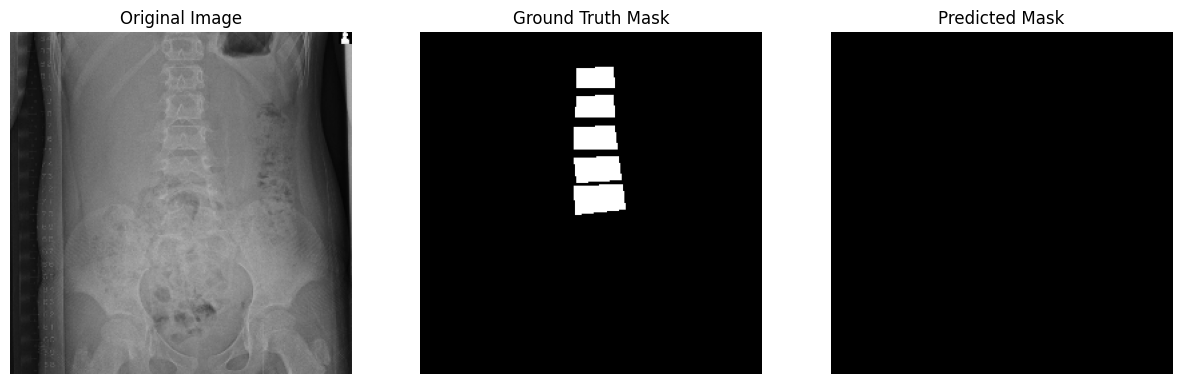

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the original image, ground truth mask, and predicted mask
def display_images(original_image, ground_truth_mask, predicted_mask, threshold=0.5):

    # Threshold the predicted mask to binarize it
    predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground Truth Mask
    axes[1].imshow(ground_truth_mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

# Example usage after prediction
# Assume val_images, val_masks, and predicted_masks are available from your validation set
# Here we'll show a random sample from the validation set (e.g., index 0)

val_image = X_val_norm[0]  # Example: the first image from validation set
val_mask = Y_val_norm[0]   # Corresponding ground truth mask
pred_mask = unet.predict(np.expand_dims(val_image, axis=0))[0]  # Predicted mask from the model

# Display the images side by side
display_images(val_image, val_mask, pred_mask)

1. 레이블을 full 마스크 사용
2. l1, l2, l3, l4,l5 나눠서 데이터 확인

* nnUnet